In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
import csv
import cv2
import shutil
import random
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications import vgg16


In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
train = pd.read_csv('./LabelledDataSet/full_df.csv')
# train

# Data visualization

In [5]:
def check_disease(df,start,end):
    df = df.iloc[:, start:end]
    disease_name, zeroCount, oneCount = [], [], []
    rowLen = len(df)
    for (column_name, column) in df.iteritems():
        disease_name.append(column_name)    
        zeroCount.append(df[column_name].value_counts()[0])
    oneCount = [rowLen - x for x in zeroCount]
    
    return disease_name, zeroCount, oneCount

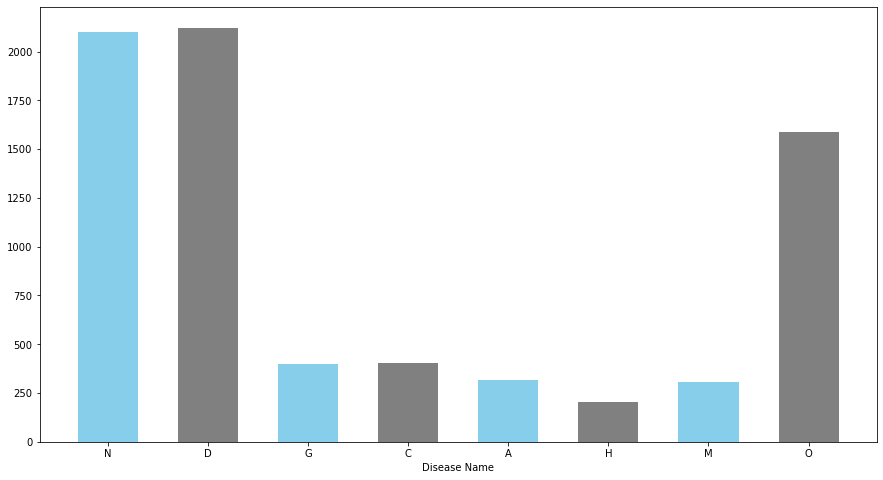

In [6]:
disease_name, zeroCount, oneCount = check_disease(train,7,15)

fig = plt.figure(figsize=(15, 8))
plt.bar(disease_name, oneCount, width=0.6, color=['skyblue', 'gray'])
plt.xlabel('Disease Name')
plt.savefig('Overall Disease.png')

In [7]:
# Drops the Column 'N', 
train=train.drop(columns=['N', 'D', 'H', 'O' ],axis=1)

#Drops the Rows
train=train[((train['G'] == 1) | (train['C'] == 1) | (train['A']== 1) | (train['M'] == 1))]

# Classes
classes=['G', 'C', 'A', 'M']

# Reset an Index of pandas dataFrame
train = train.reset_index(drop=True)

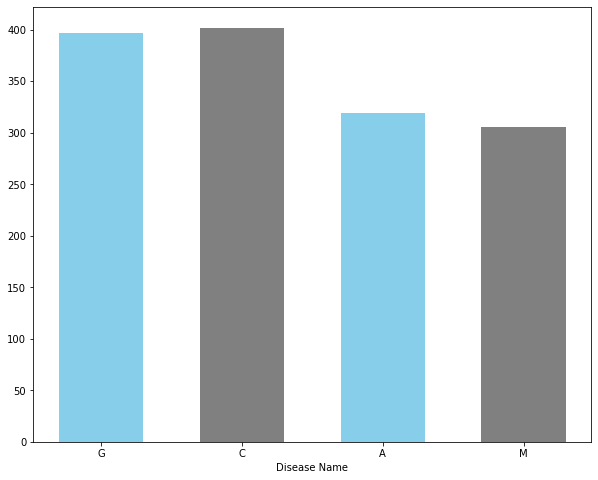

In [8]:
disease_name, zeroCount, oneCount = check_disease(train,7,11)

fig = plt.figure(figsize=(10, 8))
plt.bar(disease_name, oneCount, width=0.6, color=['skyblue', 'gray'])
plt.xlabel('Disease Name')
plt.savefig('Final Disease.png')

In [9]:
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(df[feature], palette='Set3')
        g.set_title("{} distribution".format(title))
    else:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
        if(size > 2):
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100*height/total),
                        ha="center") 
        g.set_title("Number and percentage of {}".format(title))
    plt.show() 

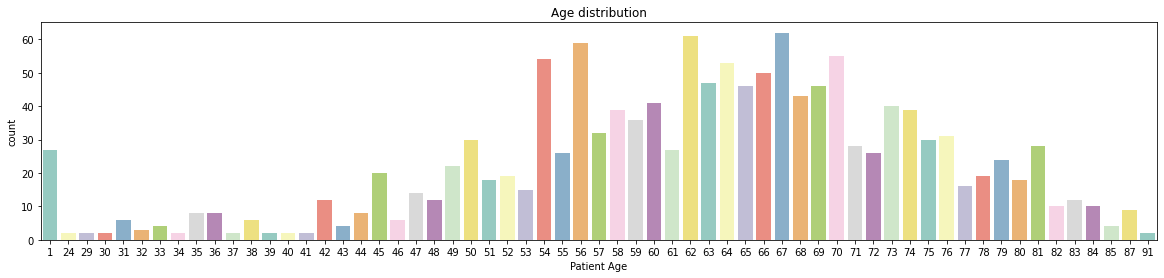

In [10]:
plot_count("Patient Age", "Age", train, size=5, show_all=True)

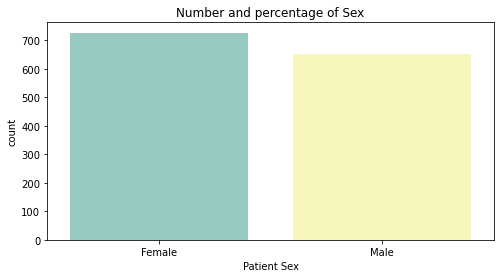

In [11]:
plot_count("Patient Sex", "Sex", train, size=2)

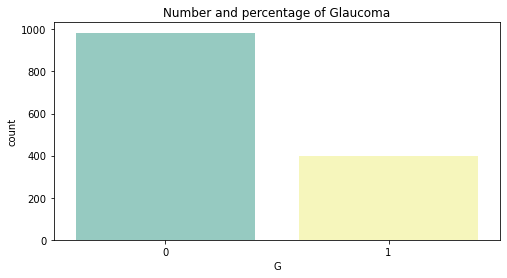

In [12]:
plot_count("G", "Glaucoma", train, size=2)

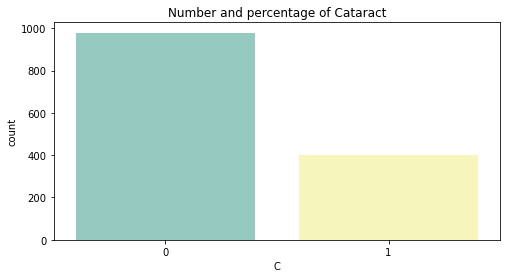

In [13]:
plot_count("C", "Cataract", train, size=2)

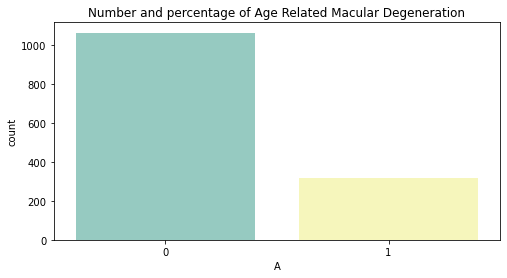

In [14]:
plot_count("A", "Age Related Macular Degeneration", train, size=2)

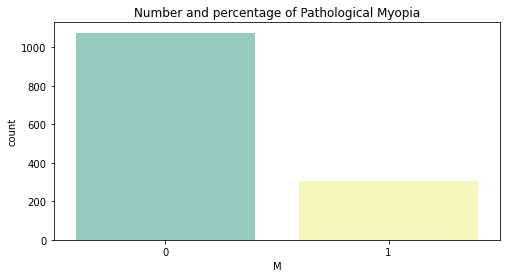

In [15]:
plot_count("M", "Pathological Myopia", train, size=2)

In [16]:
def plot_feature_distribution_grouped(feature, title, df, hue, size=4):
    plt.figure(figsize=(size*5,size*2))
    plt.title(title)
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    g = sns.countplot(df[feature], hue=df[hue], palette='Set3')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

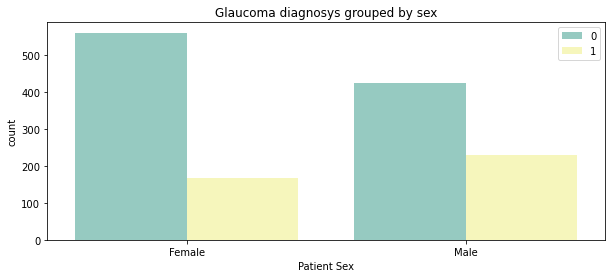

In [17]:
plot_feature_distribution_grouped('Patient Sex', 'Glaucoma diagnosys grouped by sex', train, 'G', size=2)

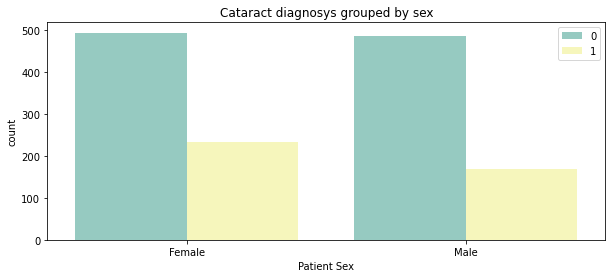

In [18]:
plot_feature_distribution_grouped('Patient Sex', 'Cataract diagnosys grouped by sex', train, 'C', size=2)

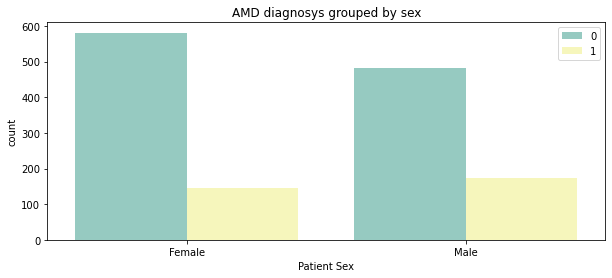

In [19]:
plot_feature_distribution_grouped('Patient Sex', 'AMD diagnosys grouped by sex', train, 'A', size=2)

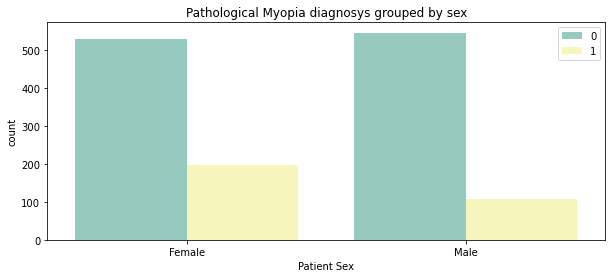

In [20]:
plot_feature_distribution_grouped('Patient Sex', 'Pathological Myopia diagnosys grouped by sex', train, 'M', size=2)

# Data Preprocessing

In [21]:
# Create List for each Disease
g_disease=[]
for i in range(len(train)):
    if(train['G'][i]==1):
        g_disease.append(train['filename'][i])
        
c_disease=[]
for i in range(len(train)):
    if(train['C'][i]==1):
        c_disease.append(train['filename'][i])

a_disease=[]
for i in range(len(train)):
    if(train['A'][i]==1):
        a_disease.append(train['filename'][i])
        
m_disease=[]
for i in range(len(train)):
    if(train['M'][i]==1):
        m_disease.append(train['filename'][i])

In [22]:
# Copy images to new path
if os.path.isdir('./data') is False:
    os.mkdir('./data')

# (Glaucoma, Cataract, Age related Macular Degeneration, Hypertension)

g_disease_save_dir='./data/glaucoma/'
os.mkdir('./data/glaucoma/')
for filename in tqdm(g_disease):
  shutil.copy('./LabelledDataSet/preprocessed_images/'+filename,g_disease_save_dir)

c_disease_save_dir='./data/cataract/'
os.mkdir('./data/cataract/')
for filename in tqdm(c_disease):
  shutil.copy('./LabelledDataSet/preprocessed_images/'+filename,c_disease_save_dir)

a_disease_save_dir='./data/age_related_macular_degeneration/'
os.mkdir('./data/age_related_macular_degeneration/')
for filename in tqdm(a_disease):
  shutil.copy('./LabelledDataSet/preprocessed_images/'+filename,a_disease_save_dir)

m_disease_save_dir='./data/pathological_myopia/'
os.mkdir('./data/pathological_myopia/')
for filename in tqdm(m_disease):
  shutil.copy('./LabelledDataSet/preprocessed_images/'+filename,m_disease_save_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 1123.90it/s]


In [23]:
base_dir = './dataset/'
if os.path.isdir(base_dir) is False:
    os.mkdir(base_dir)

#create two folders (train and validation)
train_dir = os.path.join(base_dir, 'Training')
os.mkdir(train_dir)

testing_dir = os.path.join(base_dir, 'Testing')
os.mkdir(testing_dir)

validation_dir = os.path.join(base_dir, 'Validation')
os.mkdir(validation_dir)

# Under train folder create four folders 
# (Glaucoma, Cataract, Age related Macular Degeneration, Pathological Myopia)

train_glaucoma_dir = os.path.join(train_dir, 'glaucoma')
os.mkdir(train_glaucoma_dir)

train_cataract_dir = os.path.join(train_dir, 'cataract')
os.mkdir(train_cataract_dir)

train_age_macular_dir = os.path.join(train_dir, 'age_related_macular_degeneration')
os.mkdir(train_age_macular_dir)

train_pathological_myopia_dir = os.path.join(train_dir, 'pathological_myopia')
os.mkdir(train_pathological_myopia_dir)


# Under testing folder create four folders 

testing_glaucoma_dir = os.path.join(testing_dir, 'glaucoma')
os.mkdir(testing_glaucoma_dir)

testing_cataract_dir = os.path.join(testing_dir, 'cataract')
os.mkdir(testing_cataract_dir)

testing_age_macular_dir = os.path.join(testing_dir, 'age_related_macular_degeneration')
os.mkdir(testing_age_macular_dir)

testing_pathological_myopia_dir = os.path.join(testing_dir, 'pathological_myopia')
os.mkdir(testing_pathological_myopia_dir)


# Under validation folder create four folders 
# (Glaucoma, Cataract, Age related Macular Degeneration, Pathological Myopia)

validation_glaucoma_dir = os.path.join(validation_dir, 'glaucoma')
os.mkdir(validation_glaucoma_dir)

validation_cataract_dir = os.path.join(validation_dir, 'cataract')
os.mkdir(validation_cataract_dir)

validation_age_macular_dir = os.path.join(validation_dir, 'age_related_macular_degeneration')
os.mkdir(validation_age_macular_dir)

validation_pathological_myopia_dir = os.path.join(validation_dir, 'pathological_myopia')
os.mkdir(validation_pathological_myopia_dir)

In [24]:
glaucoma_source_dir = './data/glaucoma/'
training_glaucoma_dir = './dataset/Training/glaucoma/'
testing_glaucoma_dir = './dataset/Testing/glaucoma/'
valid_glaucoma_dir = './dataset/Validation/glaucoma/'

cataract_source_dir = './data/cataract/'
training_cataract_dir = './dataset/Training/cataract/'
testing_cataract_dir = './dataset/Testing/cataract/'
valid_cataract_dir = './dataset/Validation/cataract/'

age_related_macular_degeneration_source_dir = './data/age_related_macular_degeneration/'
training_age_related_macular_degeneration_dir = './dataset/Training/age_related_macular_degeneration/'
testing_age_related_macular_degeneration_dir = './dataset/Testing/age_related_macular_degeneration/'
valid_age_related_macular_degeneration_dir = './dataset/Validation/age_related_macular_degeneration/'

pathological_myopia_source_dir = './data/pathological_myopia/'
training_pathological_myopia_dir = './dataset/Training/pathological_myopia/'
testing_pathological_myopia_dir = './dataset/Testing/pathological_myopia/'
valid_pathological_myopia_dir = './dataset/Validation/pathological_myopia/'


In [25]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    
    SIZE = (1 - SPLIT_SIZE) / 2
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) * SIZE)
    valid_length = int(len(files) * SIZE)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:training_length+testing_length]
    valid_set = shuffled_set[training_length+testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        shutil.copy(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        shutil.copy(this_file, destination)
        
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        shutil.copy(this_file, destination)

In [26]:
split_size = 0.80

split_data(glaucoma_source_dir, training_glaucoma_dir, testing_glaucoma_dir, valid_glaucoma_dir, split_size)
split_data(cataract_source_dir, training_cataract_dir, testing_cataract_dir, valid_cataract_dir, split_size)
split_data(age_related_macular_degeneration_source_dir, training_age_related_macular_degeneration_dir, testing_age_related_macular_degeneration_dir, valid_age_related_macular_degeneration_dir, split_size)
split_data(pathological_myopia_source_dir, training_pathological_myopia_dir, testing_pathological_myopia_dir, valid_pathological_myopia_dir, split_size)

In [27]:
def img_p(img_height,img_width):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                        rotation_range = 30,
                                        width_shift_range = 0.1,
                                        height_shift_range = 0.1,
                                        zoom_range = 0.1,
                                        horizontal_flip = True
                                       )
    train_generator = train_datagen.flow_from_directory('./dataset/Training/', 
                                                        target_size=(img_height,img_width), 
                                                        class_mode='categorical')
    validation_datagen = ImageDataGenerator(rescale=1/255)
    validation_generator = validation_datagen.flow_from_directory('./dataset/Validation/', 
                                                              target_size=(img_height,img_width),
                                                              class_mode='categorical')
    test_datagen = ImageDataGenerator(rescale=1/255)
    test_generator = test_datagen.flow_from_directory('./dataset/Testing/', 
                                                              target_size=(img_height,img_width),
                                                              class_mode='categorical')
    
    return train_generator,validation_generator,test_generator

# InceptionV3

In [28]:
train_generator,validation_generator,test_generator = img_p(299,299)

Found 1137 images belonging to 4 classes.
Found 140 images belonging to 4 classes.
Found 147 images belonging to 4 classes.


In [29]:
base_model = InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=True)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [30]:
# plot_model(base_model, to_file='inception_model.png', show_shapes=True, show_layer_names=True)
# display(Image.open('inception_model.png'))

In [31]:
x = base_model.layers[-2].output
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense (4, activation='softmax')(x)

In [32]:
base_m = Model(inputs=base_model.input, outputs=x)

In [33]:
base_m.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy', 
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.Precision(),   
                        tf.keras.metrics.AUC(),
                        tfa.metrics.F1Score(num_classes=4, average="macro")])

In [34]:
clf=base_m.fit(train_generator,
            validation_data = validation_generator,
            steps_per_epoch=20,
            epochs =20,
            validation_steps=5,
            verbose = 1)

Epoch 1/20
20/20 [==============================] - 294s 14s/step - loss: 0.9813 - accuracy: 0.5936 - recall: 0.5056 - precision: 0.7117 - auc: 0.8369 - f1_score: 0.5910 - val_loss: 1.2304 - val_accuracy: 0.5571 - val_recall: 0.4643 - val_precision: 0.6500 - val_auc: 0.7839 - val_f1_score: 0.4727
Epoch 2/20
20/20 [==============================] - 275s 14s/step - loss: 0.6868 - accuracy: 0.7456 - recall: 0.6880 - precision: 0.7993 - auc: 0.9202 - f1_score: 0.7479 - val_loss: 1.3103 - val_accuracy: 0.5214 - val_recall: 0.4214 - val_precision: 0.5566 - val_auc: 0.7876 - val_f1_score: 0.4985
Epoch 3/20
20/20 [==============================] - 275s 14s/step - loss: 0.5284 - accuracy: 0.8240 - recall: 0.7952 - precision: 0.8525 - auc: 0.9511 - f1_score: 0.8251 - val_loss: 1.3801 - val_accuracy: 0.5286 - val_recall: 0.5000 - val_precision: 0.5469 - val_auc: 0.8074 - val_f1_score: 0.4990
Epoch 4/20
20/20 [==============================] - 273s 14s/step - loss: 0.5287 - accuracy: 0.7920 - reca

In [35]:
base_m.evaluate(test_generator)

5/5 [==============================] - 9s 2s/step - loss: 2.4906 - accuracy: 0.7891 - recall: 0.7891 - precision: 0.7891 - auc: 0.8811 - f1_score: 0.7887


[2.490568161010742,
 0.7891156673431396,
 0.7891156673431396,
 0.7891156673431396,
 0.8810989856719971,
 0.7887111306190491]

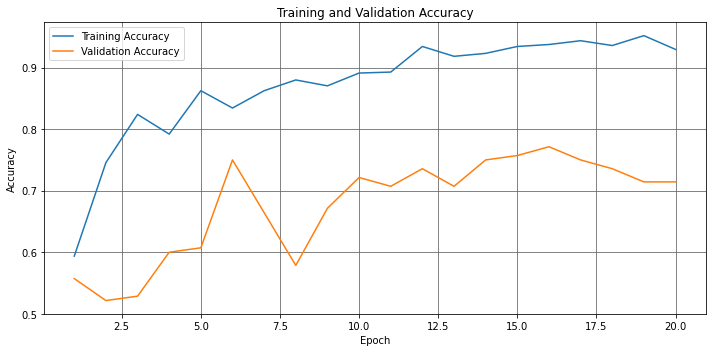

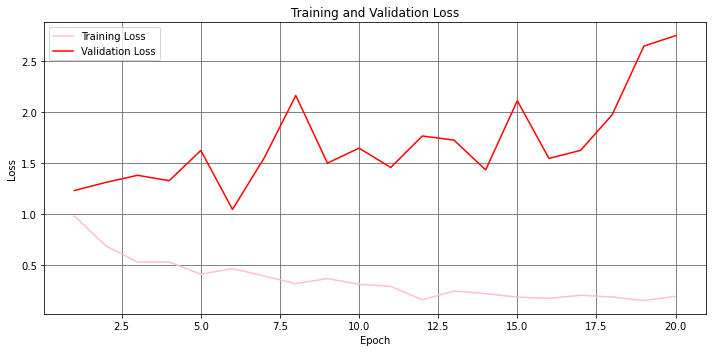

In [36]:
acc = clf.history['accuracy']
val_acc = clf.history['val_accuracy']
loss = clf.history['loss']
val_loss = clf.history['val_loss']

epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, acc,  label='Training Accuracy') #color='lightblue',
plt.plot(epochs, val_acc,  label='Validation Accuracy') #color='orange',
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.savefig('inception_accuracy.png')

#loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('inception_loss.png')


In [37]:
base_m.predict(test_generator)

5/5 [==============================] - 10s 2s/step


array([[8.42115933e-10, 4.50538135e-10, 2.47134934e-11, 1.00000000e+00],
       [1.04415268e-14, 1.00000000e+00, 2.60453060e-15, 8.93383225e-16],
       [3.00092543e-05, 4.29054035e-06, 3.45843881e-02, 9.65381384e-01],
       [1.72993154e-04, 9.99818385e-01, 8.59555712e-06, 1.81688189e-11],
       [1.12988097e-15, 1.00000000e+00, 2.06291719e-15, 1.58660642e-15],
       [1.08191434e-14, 1.00000000e+00, 2.69922512e-13, 4.91114404e-15],
       [5.05577524e-11, 1.21030901e-08, 7.08601025e-11, 1.00000000e+00],
       [9.58353630e-05, 5.57203954e-08, 9.99881148e-01, 2.29189682e-05],
       [1.30652357e-12, 1.00000000e+00, 2.57850897e-13, 3.17895294e-14],
       [7.35412478e-01, 1.07617030e-04, 2.88705784e-03, 2.61592835e-01],
       [7.86201954e-02, 9.09800291e-01, 1.15786055e-02, 8.18491799e-07],
       [9.53417420e-01, 3.38424555e-09, 4.54861894e-02, 1.09633687e-03],
       [3.17347502e-11, 1.00000000e+00, 1.95034527e-12, 4.85468410e-16],
       [9.99939084e-01, 5.99719424e-05, 7.86468206e

In [38]:
m = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

In [39]:
features = m.predict(train_generator)

36/36 [==============================] - 77s 2s/step


In [40]:
features.shape

(1137, 2048)

In [41]:
t_features = m.predict(test_generator)

5/5 [==============================] - 9s 2s/step


In [42]:
t_features.shape

(147, 2048)

In [43]:
from numpy import save
save('train_fe',features)
save('test_fe',t_features)

In [44]:
local_weights_file = './LabelledDataSet/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (299, 299, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 17, 17, 768)


In [45]:
x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(1024, activation='relu')(x)                 
x = layers.Dense (4, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [47]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch=20,
            epochs =20,
            validation_steps=5,
            verbose = 1)

Epoch 1/20
20/20 [==============================] - 107s 5s/step - loss: 3.7577 - accuracy: 0.3840 - val_loss: 0.9257 - val_accuracy: 0.6143
Epoch 2/20
20/20 [==============================] - 100s 5s/step - loss: 0.9802 - accuracy: 0.6234 - val_loss: 1.0150 - val_accuracy: 0.5357
Epoch 3/20
20/20 [==============================] - 99s 5s/step - loss: 1.0462 - accuracy: 0.5632 - val_loss: 0.9721 - val_accuracy: 0.6571
Epoch 4/20
20/20 [==============================] - 98s 5s/step - loss: 0.9099 - accuracy: 0.6562 - val_loss: 1.1343 - val_accuracy: 0.6071
Epoch 5/20
20/20 [==============================] - 98s 5s/step - loss: 0.8514 - accuracy: 0.6859 - val_loss: 0.8435 - val_accuracy: 0.7071
Epoch 6/20
20/20 [==============================] - 98s 5s/step - loss: 0.9179 - accuracy: 0.6453 - val_loss: 1.0420 - val_accuracy: 0.5714
Epoch 7/20
20/20 [==============================] - 97s 5s/step - loss: 0.7793 - accuracy: 0.6896 - val_loss: 0.8632 - val_accuracy: 0.6429
Epoch 8/20
20/20 [

In [48]:
model.evaluate(test_generator)

5/5 [==============================] - 9s 2s/step - loss: 0.6771 - accuracy: 0.7687


[0.6771495342254639, 0.7687074542045593]

In [49]:
model.save("inception_v3.h5")

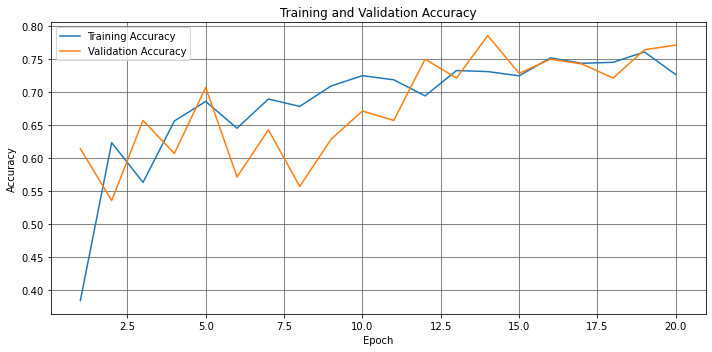

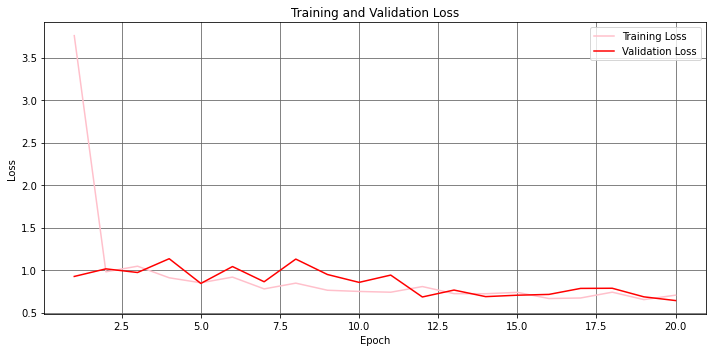

In [50]:
#plotting training values
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, acc,  label='Training Accuracy') #color='lightblue',
plt.plot(epochs, val_acc,  label='Validation Accuracy') #color='orange',
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.savefig('inception_weights_accuracy.png')

#loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('inception_weights_loss.png')

# ResNet

In [51]:
train_generator,validation_generator,test_generator = img_p(224,224)

Found 1137 images belonging to 4 classes.
Found 140 images belonging to 4 classes.
Found 147 images belonging to 4 classes.


In [52]:
resnet_m = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)

In [53]:
resnet_m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [54]:
x = resnet_m.layers[-2].output
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense (4, activation='softmax')(x)

In [55]:
resnet_m = Model(inputs=resnet_m.input, outputs=x)
resnet_m.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [56]:
res_clf = resnet_m.fit(train_generator,
            validation_data = validation_generator,
            steps_per_epoch=20,
            epochs =20,
            validation_steps=5,
            verbose = 1)

Epoch 1/20
20/20 [==============================] - 228s 11s/step - loss: 0.9047 - accuracy: 0.6448 - val_loss: 1.6290 - val_accuracy: 0.2857
Epoch 2/20
20/20 [==============================] - 214s 11s/step - loss: 0.6373 - accuracy: 0.7872 - val_loss: 3.2988 - val_accuracy: 0.2857
Epoch 3/20
20/20 [==============================] - 221s 11s/step - loss: 0.6312 - accuracy: 0.7728 - val_loss: 4.1600 - val_accuracy: 0.2857
Epoch 4/20
20/20 [==============================] - 215s 11s/step - loss: 0.5296 - accuracy: 0.8176 - val_loss: 5.4645 - val_accuracy: 0.2857
Epoch 5/20
20/20 [==============================] - 218s 11s/step - loss: 0.5162 - accuracy: 0.8304 - val_loss: 6.8352 - val_accuracy: 0.2786
Epoch 6/20
20/20 [==============================] - 215s 11s/step - loss: 0.4419 - accuracy: 0.8448 - val_loss: 12.9110 - val_accuracy: 0.2857
Epoch 7/20
20/20 [==============================] - 215s 11s/step - loss: 0.3844 - accuracy: 0.8528 - val_loss: 4.5612 - val_accuracy: 0.2857
Epoch

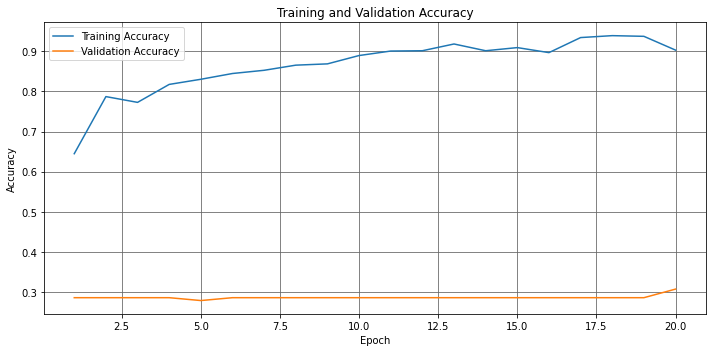

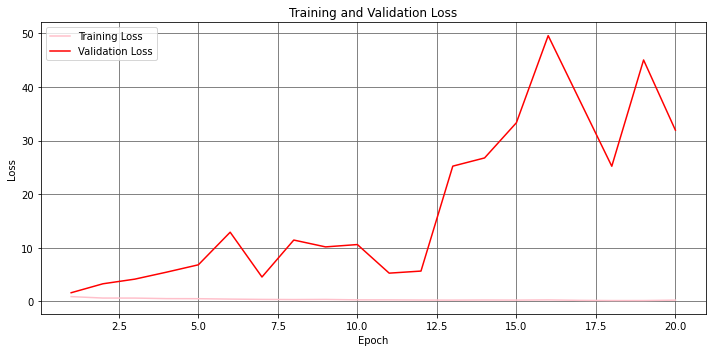

In [57]:
#plotting training values
import matplotlib.pyplot as plt

acc = res_clf.history['accuracy']
val_acc = res_clf.history['val_accuracy']
loss = res_clf.history['loss']
val_loss = res_clf.history['val_loss']

epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, acc,  label='Training Accuracy') #color='lightblue',
plt.plot(epochs, val_acc,  label='Validation Accuracy') #color='orange',
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.savefig('resnet_accuracy.png')

#loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('resnet_loss.png')

In [58]:
pre_trained_model = ResNet50(input_shape = (224,224, 3),
                        include_top = False,
                        weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

In [59]:
resNet_model = Sequential([
        pre_trained_model,
        Flatten(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dense(4, activation='softmax')])

In [60]:
resNet_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [61]:
input_shape = (None, 224, 224, 3)
resNet_model.build(input_shape)

In [62]:
resNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 1024)              102761472 
                                                                 
 dense_7 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 126,353,284
Trainable params: 102,765,572
Non-trainable params: 23,587,712
_________________________________________________________________


In [63]:
history = resNet_model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch=20,
            epochs =20,
            validation_steps=5,
            verbose = 1)

Epoch 1/20
20/20 [==============================] - 78s 4s/step - loss: 5.8358 - accuracy: 0.2672 - val_loss: 3.3421 - val_accuracy: 0.2143
Epoch 2/20
20/20 [==============================] - 78s 4s/step - loss: 2.5110 - accuracy: 0.2528 - val_loss: 3.1160 - val_accuracy: 0.2786
Epoch 3/20
20/20 [==============================] - 74s 4s/step - loss: 2.0500 - accuracy: 0.2720 - val_loss: 1.6338 - val_accuracy: 0.2286
Epoch 4/20
20/20 [==============================] - 74s 4s/step - loss: 1.8513 - accuracy: 0.2640 - val_loss: 1.7461 - val_accuracy: 0.2786
Epoch 5/20
20/20 [==============================] - 76s 4s/step - loss: 1.9721 - accuracy: 0.2547 - val_loss: 1.5074 - val_accuracy: 0.3071
Epoch 6/20
20/20 [==============================] - 75s 4s/step - loss: 1.6671 - accuracy: 0.2797 - val_loss: 1.4396 - val_accuracy: 0.3143
Epoch 7/20
20/20 [==============================] - 77s 4s/step - loss: 1.6728 - accuracy: 0.2688 - val_loss: 1.5064 - val_accuracy: 0.3571
Epoch 8/20
20/20 [==

In [64]:
resNet_model.evaluate(test_generator)

5/5 [==============================] - 10s 2s/step - loss: 1.2825 - accuracy: 0.3878


[1.2825241088867188, 0.3877550959587097]

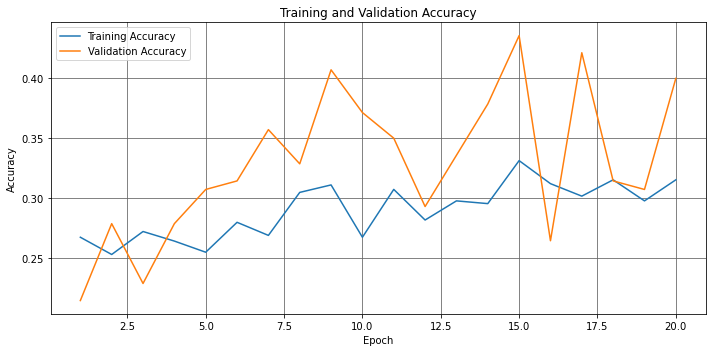

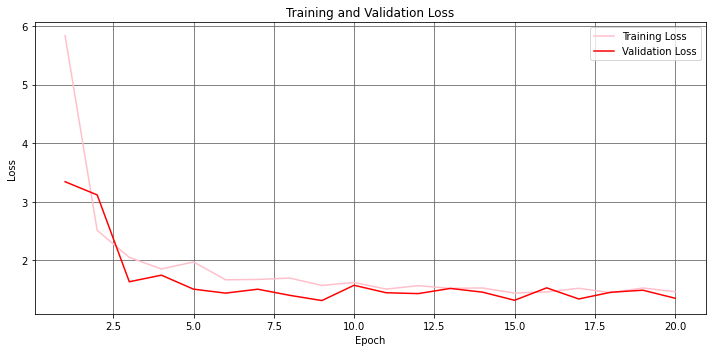

In [65]:
#plotting training values
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, acc,  label='Training Accuracy') #color='lightblue',
plt.plot(epochs, val_acc,  label='Validation Accuracy') #color='orange',
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.savefig('resnet_weights_accuracy.png')

#loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('resnet_weights_loss.png')

In [66]:
resNet_model.save("resnet_model.h5")

# VGG16

In [67]:
model=vgg16.VGG16(weights='imagenet',input_shape=(224,224,3), include_top=True, pooling="avg")

In [68]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [69]:
x = model.layers[-2].output
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense (4, activation='softmax')(x)

In [70]:
b_mvgg16 = Model(inputs=model.input, outputs=x)
# b_mvgg16.compile(optimizer = RMSprop(lr=0.0001), 
#               loss = 'categorical_crossentropy', 
#               metrics = ['accuracy'])


b_mvgg16.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [71]:
vgg_clf = b_mvgg16.fit(train_generator,
            validation_data = validation_generator,
            steps_per_epoch=20,
            epochs =20,
            validation_steps=5,
            verbose = 1)

Epoch 1/20
20/20 [==============================] - 414s 21s/step - loss: 2.7910 - accuracy: 0.2484 - val_loss: 1.5646 - val_accuracy: 0.2857
Epoch 2/20
20/20 [==============================] - 417s 21s/step - loss: 1.4724 - accuracy: 0.3047 - val_loss: 1.4083 - val_accuracy: 0.2214
Epoch 3/20
20/20 [==============================] - 405s 20s/step - loss: 1.4771 - accuracy: 0.2752 - val_loss: 1.3746 - val_accuracy: 0.3643
Epoch 4/20
20/20 [==============================] - 411s 21s/step - loss: 1.4485 - accuracy: 0.2703 - val_loss: 1.3845 - val_accuracy: 0.2357
Epoch 5/20
20/20 [==============================] - 411s 21s/step - loss: 1.5647 - accuracy: 0.3266 - val_loss: 1.3699 - val_accuracy: 0.3000
Epoch 6/20
20/20 [==============================] - 403s 20s/step - loss: 1.3586 - accuracy: 0.3472 - val_loss: 1.6937 - val_accuracy: 0.3286
Epoch 7/20
20/20 [==============================] - 410s 21s/step - loss: 1.3357 - accuracy: 0.3969 - val_loss: 1.3567 - val_accuracy: 0.4071
Epoch 

In [72]:
b_mvgg16.evaluate(test_generator)

5/5 [==============================] - 19s 4s/step - loss: 0.7496 - accuracy: 0.7143


[0.7495604157447815, 0.7142857313156128]

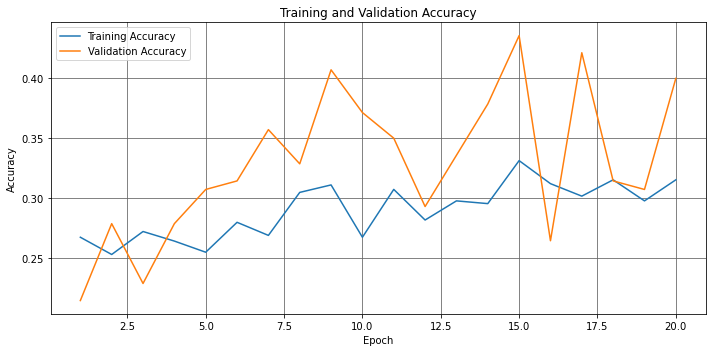

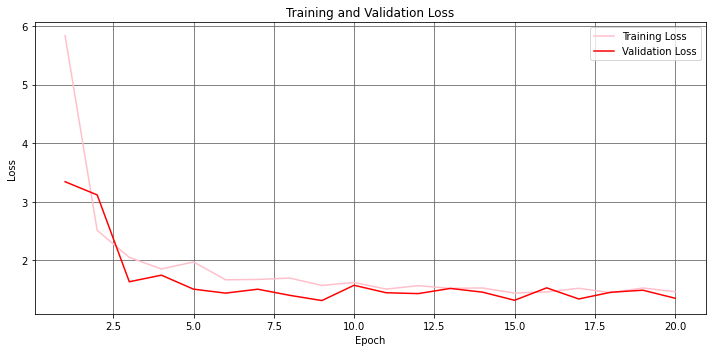

In [73]:
#plotting training values
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, acc,  label='Training Accuracy') #color='lightblue',
plt.plot(epochs, val_acc,  label='Validation Accuracy') #color='orange',
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.savefig('vgg_accuracy.png')

#loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('vgg_loss.png')

In [74]:
model_vgg = vgg16.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
model_vgg.summary()
  # Make all layers untrainable
for layer in model_vgg.layers:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [75]:
x = model_vgg.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

In [76]:
m = Model(inputs=model_vgg.input, outputs=predictions)

In [77]:
m.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [78]:
vgg_clfw = m.fit(train_generator,
                epochs=1,
                steps_per_epoch=20,
                validation_data=validation_generator,
                validation_steps=5)

20/20 [==============================] - 106s 5s/step - loss: 2.5578 - accuracy: 0.3078 - val_loss: 1.2882 - val_accuracy: 0.4857


In [79]:
m.evaluate(test_generator)

5/5 [==============================] - 18s 4s/step - loss: 1.2063 - accuracy: 0.4898


[1.20631742477417, 0.4897959232330322]

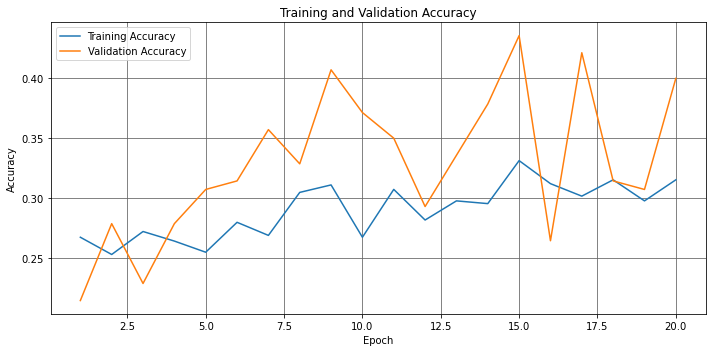

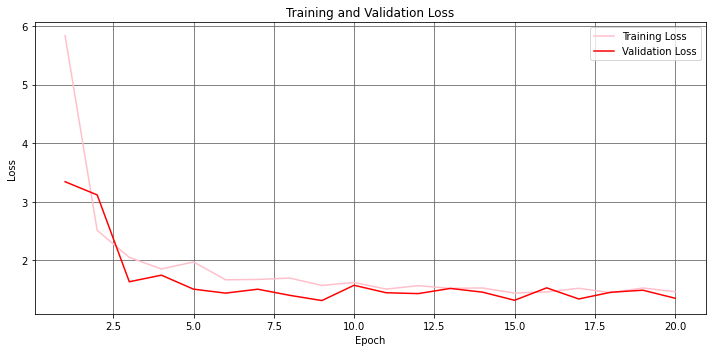

In [80]:
#plotting training values
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs, acc,  label='Training Accuracy') #color='lightblue',
plt.plot(epochs, val_acc,  label='Validation Accuracy') #color='orange',
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.savefig('vgg_weights_accuracy.png')

#loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('vgg_weights_loss.png')

In [81]:
m.save("vgg_model.h5")